In [143]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit

In [144]:
data = np.load("climbing_dataset.npz", allow_pickle=True)
X = data["X"]
y = data["y"]
names = data["names"]
global_features = data["global_features"]
print(global_features.shape, X.shape, y.shape)

(3296, 2) (3296, 4, 498) (3296,)


In [145]:
class ClimbingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape: (N, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

class ClimbingDatasetImproved(Dataset):
    def __init__(self, X1, X2, y):
        # Convert lists to tensors
        self.X1 = torch.tensor(X1, dtype=torch.float32)
        self.X2 = torch.tensor(X2, dtype=torch.float32)
        
        # Add an extra dimension for the single output
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X1)

    def __getitem__(self, idx):
        # Return a tuple of the two inputs and the output
        return (self.X1[idx], self.X2[idx]), self.y[idx]

In [146]:
class ClimbingMLP(nn.Module):
    def __init__(self, num_holds=498, num_channels=6, hidden_dim=256): #256 - > 128 > 64 is best
        super().__init__()
        input_dim = num_holds * num_channels
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256), # Add Batch Normalization
            nn.Dropout(0.6),
            nn.Linear(256, 128),
            nn.ReLU(), #
            nn.BatchNorm1d(128), # Add Batch Normalization
            nn.Dropout(0.6),
            nn.Linear(128, 64), #
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        return self.net(x)
    
class ClimbingMLPImproved(nn.Module):
    def __init__(self, num_holds=498, hold_channels=4, global_channels=4, hidden_dim=256, dropout = 0.4):
        super().__init__()
        
        # MLP for hold-wise data
        input_dim = num_holds * hold_channels
        self.hold_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout)
        )

        # MLP for global features (matching, wall angle)
        self.global_net = nn.Sequential(
            nn.Linear(global_channels, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout)
        )

        # Combine both
        self.final = nn.Sequential(
            nn.Linear(128 + 32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, hold_features, global_features):
        # hold_features: (batch, num_holds, 4)
        # global_features: (batch, 2)
        x = hold_features.view(hold_features.size(0), -1)
        hold_out = self.hold_net(x)
        global_out = self.global_net(global_features)
        combined = torch.cat([hold_out, global_out], dim=1)
        return self.final(combined)
    



In [147]:
class ClimbingMLP_V3(nn.Module):
    def __init__(self, num_holds=498, hold_channels=4, global_channels=4, hidden_dim=256, dropout = 0.4, global_hidden_dim = 32, global_output_dim = 32, hold_out = 256):
        super().__init__()
        
        # MLP for hold-wise data
        input_dim = num_holds * hold_channels
        self.hold_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hold_out),
            nn.ReLU(),
            nn.BatchNorm1d(hold_out),
            nn.Dropout(dropout)
        )

        # MLP for global features (matching, wall angle)
        self.global_net = nn.Sequential(
            nn.Linear(global_channels, global_hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(global_hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(global_hidden_dim, global_output_dim),
            nn.ReLU(),
            nn.BatchNorm1d(global_output_dim),
            nn.Dropout(dropout)
        )

        # Combine both
        self.final = nn.Sequential(
            nn.Linear(hold_out + global_output_dim, 64), # Changed from 32 to 64
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, hold_features, global_features):
        # hold_features: (batch, num_holds, 4)
        # global_features: (batch, 2)
        x = hold_features.view(hold_features.size(0), -1)
        hold_out = self.hold_net(x)
        global_out = self.global_net(global_features)
        combined = torch.cat([hold_out, global_out], dim=1)
        return self.final(combined)

In [148]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_ds = ClimbingDataset(X_train, y_train)
test_ds  = ClimbingDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32)

In [149]:
import copy
from torch.utils.data import random_split

def dataset_mse(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    n_samples = 0
    with torch.no_grad():
        for Xb, yb in loader:
            # Unpack inputs consistently (holds/global) and move to device
            Fb, Gb = Xb[0], Xb[1]
            Fb, Gb, yb = Fb.to(device), Gb.to(device), yb.to(device)
            preds = model(Fb, Gb)
            # Make sure predictions and targets have the same shape: flatten both to (N,)
            preds = preds.view(-1)
            yb_flat = yb.view(-1)
            loss = loss_fn(preds, yb_flat)
            total_loss += loss.item() * yb_flat.size(0)
            n_samples += yb_flat.size(0)
    return total_loss / n_samples if n_samples > 0 else float('nan')

# Best is 40 with one layer

def run_model(ds, dropout = 0.3, hidden_dim = 128, global_hidden_dim = 32, global_output_dim = 16, lr = 1e-3, wd = 1e-4, epochs = 500):
    generator = torch.Generator().manual_seed(42)
    n_total = len(ds)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    n_test = n_total - n_train - n_val
    train_set, val_set, test_set = random_split(ds, [n_train, n_val, n_test], generator = generator)


    train_loader = DataLoader(train_set, batch_size=64, shuffle = False)
    val_loader = DataLoader(val_set, batch_size = 64, shuffle = False)
    test_loader  = DataLoader(test_set, batch_size=64, shuffle = False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Pick model depending on layout
    #model = ClimbingMLP(num_holds=498, num_channels=6).to(device)
    model = ClimbingMLP_V3(dropout = dropout, hidden_dim = hidden_dim, global_hidden_dim = global_hidden_dim, global_output_dim = global_output_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # Changed learning rate to 1e-2 from 1e-3 


    #New Train
    best_loss = float('inf')
    best_model_state = None
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for Xb, yb in train_loader:
            Fb, Gb = Xb[0], Xb[1]
            Fb, Gb, yb = Fb.to(device), Gb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(Fb, Gb)
            # compute loss with matching shapes
            loss = criterion(preds.view(-1), yb.view(-1))
            loss.backward()
            optimizer.step()
            # Accumulate batch loss scaled by number of samples in the batch
            total_loss += loss.item() * Fb.size(0)
        # Use actual training set size as denominator
        mse = total_loss / len(train_set)
        if mse < best_loss:
            best_loss = mse
            best_model_state = copy.deepcopy(model.state_dict())
        #print(f"Epoch {epoch+1:02d} | Train Loss: {total_loss / len(train_set):.4f}")

    # restore best model before evaluating
    model.load_state_dict(best_model_state)
    val_loss = dataset_mse(model, val_loader, criterion, device)
    test_loss = dataset_mse(model, test_loader, criterion, device) 
    return val_loss, test_loss

import itertools

def hyperparam_search(dataset):
    dropout  = [0.3, 0.4, 0.5]
    weight_decay = [1e-4, 1e-3, 1e-2]

    search_space = list(itertools.product(dropout, weight_decay))
    results = []


    for i, (do, wd) in enumerate(search_space, 1):
        # Use a single, flushed print so notebook frontends show output promptly
        print(f"▶️ [{i}/{len(search_space)}] Dropout={do} Weight Decay {wd}", flush=True)
        val_mse, test_mse = run_model(
            dataset,
            dropout=do,
            wd = wd,
            epochs=250,
        )
        results.append({
            'dropout': do,
            'weight_decay' : wd,
            'val_mse': val_mse,
            'test_mse': test_mse
        })
        print(f"   → val={val_mse:.3f}, test={test_mse:.3f}\n")

    # sort by best validation MSE
    results = sorted(results, key=lambda x: x['val_mse'])
    print("✅ Best Config:")
    print(results[0])
    return results


ds = ClimbingDatasetImproved(X, global_features,  y)
#result = hyperparam_search(ds)


In [ ]:
#Best model with samples > 75 ascents
#model = ClimbingMLP_V3(dropout = 0.4, hidden_dim = 256, global_hidden_dim = 32, global_output_dim = 16, hold_channels = 2).to(device)
#criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2) # Changed learning rate to 1e-2 from 1e-3 

from sklearn.model_selection import StratifiedShuffleSplit

ds = ClimbingDatasetImproved(X, global_features,  y)
generator = torch.Generator().manual_seed(42)
n_total = len(ds)
n_train = int(0.8 * n_total)
n_test = n_total - n_train
train_set, test_set = random_split(ds, [n_train, n_test], generator = generator)
epochs = 500
bins = np.arange(10, 31, 1)
y_binned = np.digitize(y, bins, right=False)

X_train, global_train, y_train = None, None, None
X_test, global_test, y_test = None, None, None


splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(np.zeros(len(y)), y_binned):
    X_train, X_test = X[train_idx], X[test_idx]
    global_train, global_test = global_features[train_idx], global_features[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

train_ds = ClimbingDatasetImproved(X_train, global_train, y_train)
test_ds = ClimbingDatasetImproved(X_test, global_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle = False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle = False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pick model depending on layout
#model = ClimbingMLP(num_holds=498, num_channels=6).to(device)
model = ClimbingMLP_V3(dropout = 0.4, hidden_dim = 1024, global_hidden_dim = 32, global_output_dim = 16, hold_channels = 4, global_channels = 2, hold_out = 256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2) # Changed learning rate to 1e-2 from 1e-3 


#New Train
best_loss = float('inf')
best_model_state = None
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for Xb, yb in train_loader:
        Fb, Gb = Xb[0], Xb[1]
        Fb, Gb, yb = Fb.to(device), Gb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Fb, Gb)
        # compute loss with matching shapes
        loss = criterion(preds.view(-1), yb.view(-1))
        loss.backward()
        optimizer.step()
        # Accumulate batch loss scaled by number of samples in the batch
        total_loss += loss.item() * Fb.size(0)
    # Use actual training set size as denominator
    mse = total_loss / len(train_set)
    if mse < best_loss:
        best_loss = mse
        best_model_state = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch+1:02d} | Train Loss: {total_loss / len(train_set):.4f}")

# restore best model before evaluating
model.load_state_dict(best_model_state)
test_loss = dataset_mse(model, test_loader, criterion, device) 


Epoch 01 | Train Loss: 285.6727
Epoch 02 | Train Loss: 48.8562
Epoch 03 | Train Loss: 12.4393
Epoch 04 | Train Loss: 6.5784
Epoch 05 | Train Loss: 5.2975
Epoch 06 | Train Loss: 4.5578
Epoch 07 | Train Loss: 3.9976
Epoch 08 | Train Loss: 3.5986
Epoch 09 | Train Loss: 3.5455
Epoch 10 | Train Loss: 3.1086
Epoch 11 | Train Loss: 2.9879
Epoch 12 | Train Loss: 3.1583
Epoch 13 | Train Loss: 3.1624
Epoch 14 | Train Loss: 3.0316
Epoch 15 | Train Loss: 3.0176
Epoch 16 | Train Loss: 3.5396


In [ ]:
# [28/81] LR=0.0003, WD=0.0001, H=128, Drop=0.3→ val=1.986, test=1.689
model.load_state_dict(best_model_state)
model.eval() # 3.5 by far the best
preds, actual = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Fb, Gb = Xb[0], Xb[1]
        Fb, Gb = Fb.to(device), Gb.to(device)
        preds.append(model(Fb, Gb).cpu().numpy())
        actual.append(yb.numpy())

preds = np.concatenate(preds)
actual = np.concatenate(actual)

mse = np.mean((preds - actual) ** 2)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.5167


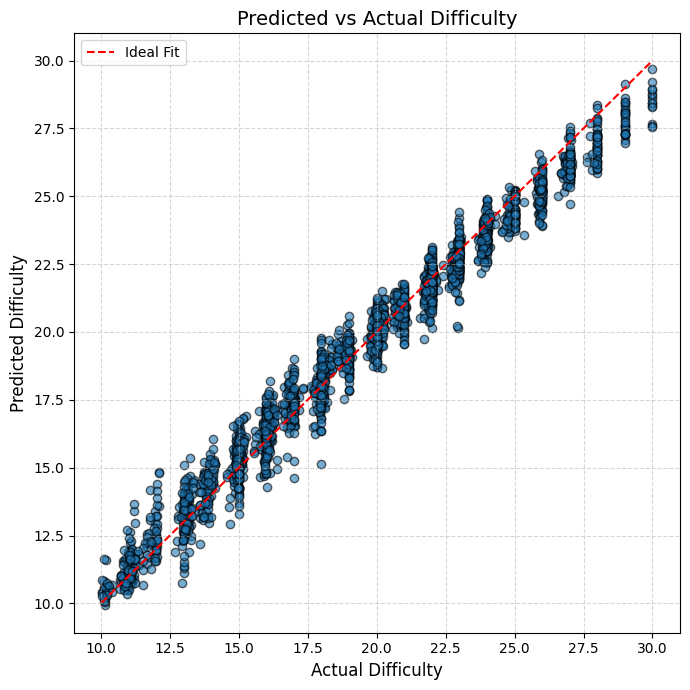

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(7,7))
plt.scatter(actual, preds, alpha=0.6, edgecolor='k')
plt.plot([actual.min(), actual.max()],
         [actual.min(), actual.max()],
         'r--', label='Ideal Fit')

plt.xlabel("Actual Difficulty", fontsize=12)
plt.ylabel("Predicted Difficulty", fontsize=12)
plt.title("Predicted vs Actual Difficulty", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show() # Best Model is feature contain (Feet, hands, mid, finish, h, w) and global with (num_hands, num_feet, matching, angle)